# Preliminaries + Installs

These instructions are for Python 3.10
### Fix Pillow
* `cd /usr/lib/python3/dist-packages`
* `sudo rm -rf pillow-10.2.0.egg-info`
* `python3.10 -m pip install Pillow --user`
### Install Ollama
* `cd /tmp`
* `curl -fsSL https://ollama.com/install.sh | sh`
* Test, Optional (2GB download): `ollama run llama3.2`, Type `/bye` when done
### Install Langchain
* `python3.10 -m pip install langchain langchain_community langchain_chroma langchain_ollama llama-index-legacy langchain-unstructured --user`
* `python3.10 -m pip install pypdf "unstructured[pdf]" --user` , This needed to be separate for some reason.
### Install SQLite ( >= 3.35.0 required, This will install 3.46 )
* `sudo apt install libreadline-dev python3.10-dev`
* `wget https://sqlite.org/2024/sqlite-autoconf-3460100.tar.gz`
* `tar -xvf sqlite-autoconf-3460100.tar.gz && cd sqlite-autoconf-3460100`
* `./configure`
* `make`
* `sudo make install`
* `python3.10 -m pip uninstall pysqlite3`
* `python3.10 -m pip install pysqlite3-binary --user`

# Build/Expand Document Database + Embeddings

## State

In [1]:
from os import environ, path
import time, sys, json
now = time.time

environ["_RAG_STATE_PATH"] = "data/state.json"

RAGstate = {
    'libDocs' : list(),
    'pages'   : dict(),
}

def save_state():
    global RAGstate
    with open( environ["_RAG_STATE_PATH"], 'w' ) as f:
        json.dump( RAGstate, f, indent = 4 )

def load_state():
    global RAGstate
    try:
        with open( environ["_RAG_STATE_PATH"], 'r' ) as f:
            RAGstate = json.load(f)
    except FileNotFoundError as e:
        print( f"Could not load {environ['_RAG_STATE_PATH']}!\n{e}" )

load_state()

## Helper Functions

In [2]:
from uuid import uuid4

def safe_str( data ):
    """Filters out invalid UTF-8 characters from a string."""
    return str( data ).encode( 'utf-8', 'ignore' ).decode( 'utf-8' )

def gen_ID():
    """ Generate a unique ID """
    return safe_str( uuid4() )

def pull_ollama_model( modelStr ):
    """ Pull a named model from Ollama and store it wherever """
    print( f"About to save '{modelStr}'.\nThis will spew a lot of text on the first run..." )
    os.system( f"ollama pull {modelStr}" )



## Copy PDFs

In [3]:
import os
from os import path, makedirs
# from aa_scrape_PDF import copy_pdfs

environ["_RAG_PDF_SOURCE"] = "/media/james/FILEPILE/$_Robust_Planning/Literature/References/storage"
environ["_RAG_PDF_DESTIN"] = "data/input/pdf"
environ["_RAG_PDF_ERROR"]  = "data/input/BAD_PDF"
environ["_RAG_PAGE_DESTN"] = "data/input/pages"
environ["_RAG_VERBOSE"]    =    ""
environ["_RAG_DOC_ADD"]    =   "400" #"25" #"200"
environ["_RAG_DOC_LIMIT"]  = "20000"
environ["_RAG_DOC_DBASE"]  = "lit_pdf"

if not path.exists( environ["_RAG_PDF_ERROR"] ):
    makedirs( environ["_RAG_PDF_ERROR"] )


## Determine if more docs will be loaded this session

In [4]:
%%capture
# Loading the vector store sometimes spews warnings

__import__('pysqlite3')
sys.modules['sqlite3'] = sys.modules.pop( 'pysqlite3' )
import chromadb
from langchain_chroma import Chroma


persistent_client = chromadb.PersistentClient();
collection        = persistent_client.get_or_create_collection( environ["_RAG_DOC_DBASE"] );

pdfs_drct   = environ["_RAG_PDF_DESTIN"]
eror_drct   = environ["_RAG_PDF_ERROR" ]
fNames      = [item for item in os.listdir( pdfs_drct ) if (str( item ).split('.')[-1].lower() == 'pdf')]

environ["_RAG_PDF_COUNT"   ] = str( len( fNames ) )
environ["_RAG_DOCDB_COUNT" ] = str( collection.count() )
environ["_RAG_DOCDB_REMAIN"] = str( min( int(environ["_RAG_DOC_LIMIT"])-len(RAGstate['libDocs']), int(environ["_RAG_DOC_ADD"]) ) )


In [5]:
from utils import copy_pdfs

print( f"{environ['_RAG_PDF_COUNT' ]} input PDFs exist!" )
print( f"{environ['_RAG_DOCDB_COUNT' ]} vector records exist!" )
print( f"{environ['_RAG_DOCDB_REMAIN']} files will be copied!" )

copy_pdfs( environ["_RAG_PDF_SOURCE"], environ["_RAG_PDF_DESTIN"], 
           int(environ['_RAG_DOCDB_REMAIN']), verbose = environ["_RAG_VERBOSE"] )

9066 input PDFs exist!
211699 vector records exist!
400 files will be copied!
..........................................................................................................................................................................................


## Load PDFs by page chunks

### https://python.langchain.com/docs/how_to/document_loader_pdf/

* `python3.10 -m pip install pypdf langchain-unstructured "unstructured[pdf]" --user`
* `apt install tesseract-ocr`

In [6]:

def collect_unique_metadata_by_key( key ):
    """ Return a list of unqiue metadata values from the vector store by `key` """
    global collection
    unique = set()
    for result in collection.get()['metadatas']:
       if key in result:
           unique.add( result[key] )
    return list( unique )


def find_unread_PDFs_at_input():
    """ Return a list of PDF paths that do NOT have pages in the vector store """
    global RAGstate
    inputPDFs = collect_unique_metadata_by_key( 'source' )
    rtnPaths  = list()
    for pdf in inputPDFs:
        if pdf not in RAGstate['libDocs']:
            rtnPaths.append( pdf )
    return rtnPaths
            

In [7]:
import os, shutil
from collections import deque
from langchain_community.document_loaders import PyPDFLoader

pages = deque() # Fast append


# needToParse = find_unread_PDFs_at_input()
# fNames.extend( needToParse )

print( f"There are {len(fNames)} candidate files!" )

if len( fNames ) > 0:
    bgn    = now()
    lastLn = 0
    Nexist = 0
    
    for i, fNam in enumerate( fNames ):
        file_path = str( path.join( pdfs_drct, fNam ) ) # fNam # str( path.join( pdfs_drct, fNam ) )
        if file_path not in RAGstate['libDocs']:
            try:
                loader    = PyPDFLoader( file_path )
                async for page in loader.alazy_load():
                    pages.append( page )
                print( f"{i+1}:{len(pages)-lastLn}:{len(pages)}", end = ', ', flush = True )
                lastLn = len(pages)
            except Exception as e:
                print( f"ERROR:{e}", end = ', ', flush = True )
                try:
                    shutil.move( file_path, path.join( eror_drct, fNam ) )
                except Exception as e:
                    print( f"FAILED to move {file_path} --to-> {path.join( eror_drct, fNam )}" )
            except asyncio.CancelledError as e:
                print( f"Load operation cancelled by user" )
                raise e
        else:
            Nexist += 1
                    
    print()
    pages = list( pages )
    print( f"Read {len(pages)} pages in {(now()-bgn)/60.0:.2f} minutes! (Skipped {Nexist} existing PDFs.)" )

save_state()

There are 9066 candidate files!
151:14:14, 387:10:24, 622:12:36, 632:15:51, 655:13:64, 

could not convert string to float: '0.00-30' : FloatObject (b'0.00-30') invalid; use 0.0 instead
could not convert string to float: '0.00-30' : FloatObject (b'0.00-30') invalid; use 0.0 instead
could not convert string to float: '0.00-30' : FloatObject (b'0.00-30') invalid; use 0.0 instead
could not convert string to float: '0.00-30' : FloatObject (b'0.00-30') invalid; use 0.0 instead


716:30:94, 807:39:133, 938:24:157, ERROR:Stream has ended unexpectedly, 1310:8:165, 1546:7:172, 1707:22:194, 1711:27:221, 1712:67:288, 2194:42:330, 2282:18:348, 2347:18:366, 2691:21:387, 2746:11:398, 2808:27:425, 3051:7:432, ERROR:Invalid Elementary Object starting with b'\x03' @0: b'\x03\xff', 3128:30:462, 3162:23:485, 3262:18:503, 3268:175:678, 3326:12:690, 3534:8:698, 3882:11:709, 3938:7:716, 3993:11:727, 4057:15:742, 4163:6:748, 4244:27:775, 4473:34:809, 4569:26:835, 4584:15:850, 4587:14:864, 4600:12:876, 4606:10:886, 4649:9:895, 4699:10:905, 4848:10:915, ERROR:Cannot read an empty file, 5060:124:1039, 5309:18:1057, 5460:8:1065, 5520:38:1103, 5581:17:1120, 5637:8:1128, 5735:16:1144, 5738:1:1145, 6101:159:1304, 6176:15:1319, 6321:8:1327, 6431:18:1345, 6636:11:1356, 6665:7:1363, 6791:20:1383, 6803:10:1393, 6913:11:1404, 6961:204:1608, 6980:8:1616, 7158:28:1644, 7388:11:1655, 7739:5:1660, 7960:24:1684, 

/Prev=0 in the trailer - assuming there is no previous xref table


8041:1:1685, 8193:9:1694, 8302:15:1709, 8336:1:1710, 8376:16:1726, 8382:12:1738, 8385:20:1758, 8400:5:1763, 8718:9:1772, 8728:8:1780, 8747:90:1870, 8924:5:1875, 8988:19:1894, 8998:30:1924, 9016:21:1945, 9033:131:2076, 9041:101:2177, 9061:39:2216, 
Read 2216 pages in 1.59 minutes! (Skipped 8981 existing PDFs.)


In [8]:
# print(f"{pages[0].metadata}\n")
# print(pages[0].page_content)

## Load the text embedding model

In [9]:
import sys, os, time
now = time.time

from langchain_ollama import OllamaEmbeddings

pull_ollama_model( "all-minilm" )

local_embeddings = OllamaEmbeddings( model = "all-minilm" )

About to save 'all-minilm'.
This will spew a lot of text on the first run...


pulling manifest ⠙ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest 
pulling 797b70c4edf8... 100% ▕████████████████▏  45 MB                         
pulling c71d239df917... 100% ▕████████████████▏  11 KB                         
pulling 85011998c600... 100% ▕████████████████▏   16 B                         
pulling 548455b72658... 100% ▕████████████████▏  407 B                         
verifying sha256 digest 
writing manifest 
success 


## Populate document vector database (of pages)

In [10]:
import base64
import io

import fitz, pymupdf
from PIL import Image


def pdf_page_to_base64( pdf_path: str, page_number: int ):
    zoom_x       = 1.5  # horizontal zoom
    zoom_y       = 1.5  # vertical zoom
    mat          = pymupdf.Matrix( zoom_x, zoom_y )
    pdf_document = fitz.open( pdf_path )
    page         = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix          = page.get_pixmap( matrix = mat )
    img          = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    buffer       = io.BytesIO()
    
    img.save( buffer, format="PNG" )

    return base64.b64encode( buffer.getvalue() ).decode("utf-8")

In [11]:
import pickle

if not path.exists( environ["_RAG_PAGE_DESTN"] ):
    makedirs( environ["_RAG_PAGE_DESTN"] )


def get_page_meta_key( source, page ):
    """ Generate a (probably not) unique page key with useful data that can also be used for sorting """
    return str( source ).split('/')[-1].replace(' ','') + '_' + str( page )


if int(environ["_RAG_DOCDB_REMAIN"]) > 0:
    bgn = now()
    docIDs  = [str( gen_ID() ) for _ in range( len(pages) )]
    dcmnts  = [str( pg.page_content ) for pg in pages]
    metaDt  = deque() # Fast append
    d       = 50
    readSet = set([])

    for i, pg in enumerate( pages ):

        id_i  = docIDs[i]
        
        # Save Text Metadata #
        mDct = pg.metadata
        mDct['metakey'] = get_page_meta_key( pg.metadata['source'], pg.metadata['page'] )
        mDct['docID'  ] = id_i
        metaDt.append( mDct )

        src = pg.metadata['source']

        #  vv- Quick Search -vv     vvvvv--- Long Search ---vvvvvvvv
        if (src not in readSet) and (src not in RAGstate['libDocs']):
            readSet.add( src )
            RAGstate['libDocs'].append( src )

        # Save PDF Page image #
        try:
            pkl_i = path.join( environ["_RAG_PAGE_DESTN"], f"{id_i}.pkl" )
            pgPic = pdf_page_to_base64( pg.metadata['source'], pg.metadata['page'] )
            
            with open( pkl_i, 'wb' ) as f:
                RAGstate['pages'][ id_i ] = str( pkl_i )
                pickle.dump( pgPic, f )
        except Exception as e:
            print( f"Could NOT save image ID {id_i}!, {e}" )

        if (i % d == 0):
            print( '.', end='', flush = True )
    print()

    metaDt = list( metaDt )
    
    collection.add(
        ids       = docIDs, 
        metadatas = metaDt,
        documents = dcmnts
    )
    print( f"Added {len(dcmnts)} documents in {(now()-bgn)/60.0:.2f} minutes!" )

save_state()



......................................MuPDF error: syntax error: could not parse color space (1177 0 R)

MuPDF error: syntax error: could not parse color space (283 0 R)

MuPDF error: syntax error: could not parse color space (439 0 R)

MuPDF error: syntax error: could not parse color space (503 0 R)

MuPDF error: syntax error: could not parse color space (548 0 R)

MuPDF error: syntax error: could not parse color space (635 0 R)

MuPDF error: syntax error: could not parse color space (772 0 R)

MuPDF error: syntax error: could not parse color space (896 0 R)

MuPDF error: syntax error: could not parse color space (1097 0 R)

......MuPDF error: syntax error: could not parse color space (513 0 R)

.MuPDF error: syntax error: could not parse color space (671 0 R)

MuPDF error: syntax error: could not parse color space (691 0 R)

MuPDF error: syntax error: could not parse color space (788 0 R)

MuPDF error: syntax error: could not parse color space (807 0 R)

MuPDF error: syntax error: co

# Create vector store

In [12]:
bgn = now()
vector_store_from_client = Chroma(
    client             = persistent_client,
    collection_name    = environ["_RAG_DOC_DBASE"],
    embedding_function = local_embeddings,
)
print( f"Built vector store in {(now()-bgn):.4f} seconds!" )

Built vector store in 0.0038 seconds!


# Load VLM

In [13]:
from langchain_ollama import ChatOllama

pull_ollama_model( "llava" )

llm = ChatOllama(
    model="llava",
)

About to save 'llava'.
This will spew a lot of text on the first run...


pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest 
pulling 170370233dd5... 100% ▕████████████████▏ 4.1 GB                         
pulling 72d6f08a42f6... 100% ▕████████████████▏ 624 MB                         
pulling 43070e2d4e53... 100% ▕████████████████▏  11 KB                         
pulling c43332387573... 100% ▕████████████████▏   67 B                         
pulling ed11eda7790d... 100% ▕████████████████▏   30 B                         
pulling 7c658f9561e5... 100% ▕████████████████▏  564 B                         
verifying sha256 digest 
writing manifest 
success 


# Setup LangChain

In [14]:
os.environ["LANGCHAIN_TRACING_V1"] = "false"
os.environ["LANGCHAIN_TRACING_V2"] = "false"

# from langchain import hub
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser

# Retrieve and generate using the relevant snippets of the blog.
retriever = vector_store_from_client.as_retriever()

# Instantiation using from_template (recommended)
prompt1 = PromptTemplate( 
    template = """You are an expert assistant capable of interpreting textual information to provide accurate 
                  and detailed responses. You are provided with the following data:
                  Context: {docData}
                  Text query: {userQuery}
                  Use your understanding of the provided context to generate a response to based on 
                  relevant, up-to-date information. Ensure your answer is factually accurate, detailed, and leverages academic 
                  sources where possible. If additional context is required for clarification, request it from the user.""",
    input_variables = ["docData","userQuery"],
)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain1 = (
    { "docData": retriever | format_docs, 
      "userQuery": RunnablePassthrough()}
    | prompt1
    | llm
    | StrOutputParser()
)

In [15]:
def ask_with_sources( q ):
    retrieved_docs = retriever.invoke( q )
    generated_ansr = rag_chain1.invoke( q )
    return {
        'response' : generated_ansr,
        'sources'  : retrieved_docs,
    }

In [16]:
def fetch_local_pages( sourceList ):
    global RAGstate
    rtnObjs = list()
    for source in sourceList:
        if source.metadata['docID'] in RAGstate['pages']:
            pklPath = RAGstate['pages'][ source.metadata['docID'] ]
            with open( pklPath, 'rb' ) as f:
                obj_i = pickle.load( f )
                rtnObjs.append( obj_i )
        else:
            print( f"No page with ID {source.metadata['docID']}" )
    return rtnObjs

In [17]:
from pprint import pprint
from IPython.display import Image as IPImage
from IPython.display import display
from langchain_core.messages import HumanMessage

def deep_doc_ask( q ):
    bgn = now()
    res = ask_with_sources( q ) 
    pprint( res['response'] )
    print( f"Initial LLM summary took {now()-bgn:.2f} seconds to process!" )
    
    pag = fetch_local_pages( res['sources'] )

    for p in pag:
        display( IPImage( data = base64.b64decode( p ) ) )
        message = HumanMessage(
            content=[
                {"type": "text", "text": q},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{p}"},
                },
            ],
        )
        bgn = now()
        response = llm.invoke( [message] )
        print( f"LLM query took {now()-bgn:.2f} seconds to process!" )
        pprint( response.content )

(' Nuclear fusion in a confined plasma requires specific conditions to achieve '
 'ignition and sustained energy production. The three key parameters that '
 'define these conditions are plasma density ( n\\_e), temperature ( T), and '
 'confinement time ( s). A plasma at T = 25 keV and ne = 1.5/C2 \\* 10^20 m^-3 '
 'for 1 s can achieve ignition (Green & ITER Team, 2003). Initial efforts to '
 'achieve these conditions began in the 1950s, with progression through '
 'multiple generations of fusion devices and experiments.\n'
 '\n'
 'A critical aspect of achieving nuclear fusion is the confinement of the '
 'plasma within a magnetic confinement device, such as a tokamak or '
 'stellarator. The energy release from nuclear fusion is volume-dependent, '
 'while the energy loss is surface area-dependent, making it challenging to '
 'achieve self-sustaining conditions (LaBrucherie, 2013).\n'
 '\n'
 'The Lawson Criterion is often used to determine if plasma conditions can '
 'achieve ignition

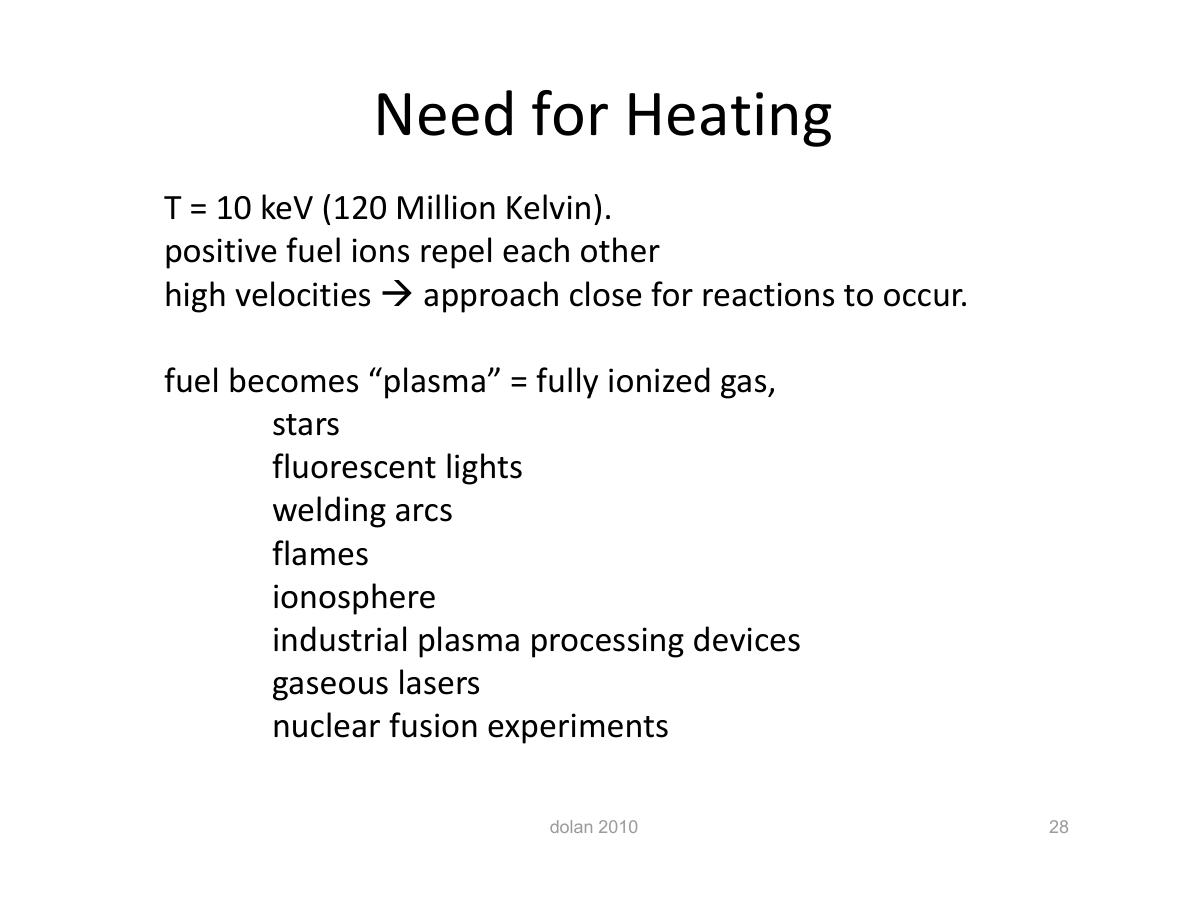

LLM query took 29.32 seconds to process!
(' The image displays a slide with text that explains the conditions necessary '
 'for nuclear fusion in a confined plasma. According to the slide, these '
 'conditions include:\n'
 '\n'
 '1. A temperature of 10^6 K (which is equivalent to 92 million degrees '
 'Celsius) and above. This high temperature allows for the acceleration of '
 'atoms to velocities where their kinetic energy can overcome the Coulomb '
 'force that repels them at normal temperatures, enabling fusion to occur.\n'
 '\n'
 '2. A density of 10^6 g/cm3 (grams per cubic centimeter) or higher. This is '
 'necessary to ensure that there are enough particles in close proximity for '
 'the nuclear reactions to take place efficiently.\n'
 '\n'
 '3. Fuel: typically a mixture of deuterium and tritium, although other fuel '
 'combinations may be used depending on the specific reactor design.\n'
 '\n'
 '4. The presence of magnetic fields, often generated by electromagnets or '
 'other m

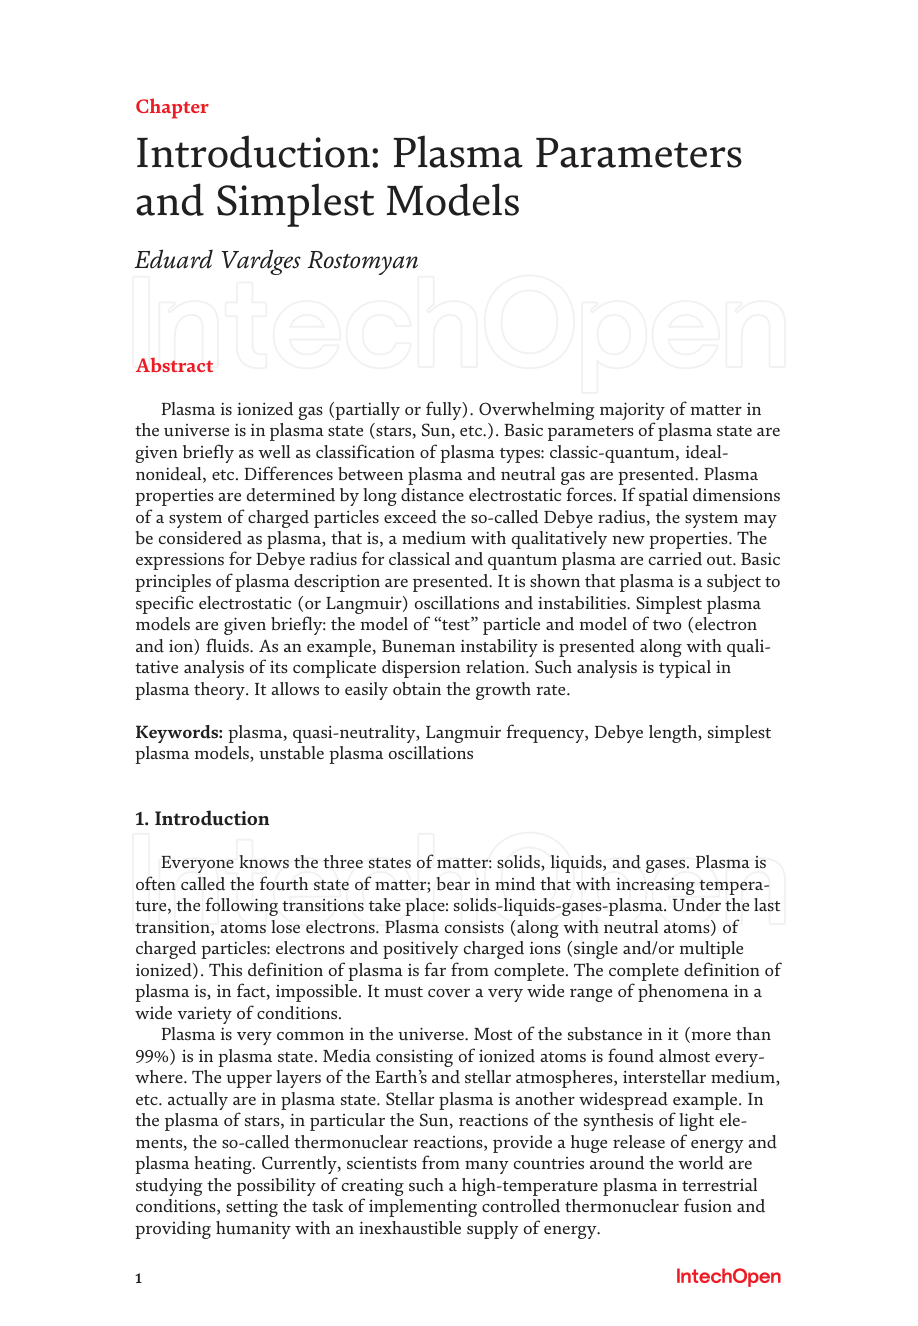

LLM query took 53.25 seconds to process!
(" The image you've shared is of a paper or article that discusses the "
 "introduction to plasma parameters and simplest models. It doesn't appear to "
 'be directly related to nuclear fusion in confined plasmas, as it seems to '
 'cover a broader topic of plasma physics. However, if we were to imagine the '
 "content of such an article for nuclear fusion, here's a general outline that "
 'might discuss the conditions necessary for nuclear fusion in confined '
 'plasmas:\n'
 '\n'
 '1. **Temperature**: Nuclear fusion requires extremely high temperatures, '
 'typically around 100 million degrees Celsius or more. This is because the '
 'reaction that occurs involves fusing two atomic nuclei together at such '
 'speeds and heat that they overcome their natural repulsion and combine to '
 'form a new element, releasing energy in the process.\n'
 '\n'
 '2. **Pressure**: In addition to high temperatures, confined plasmas also '
 'require a certain lev

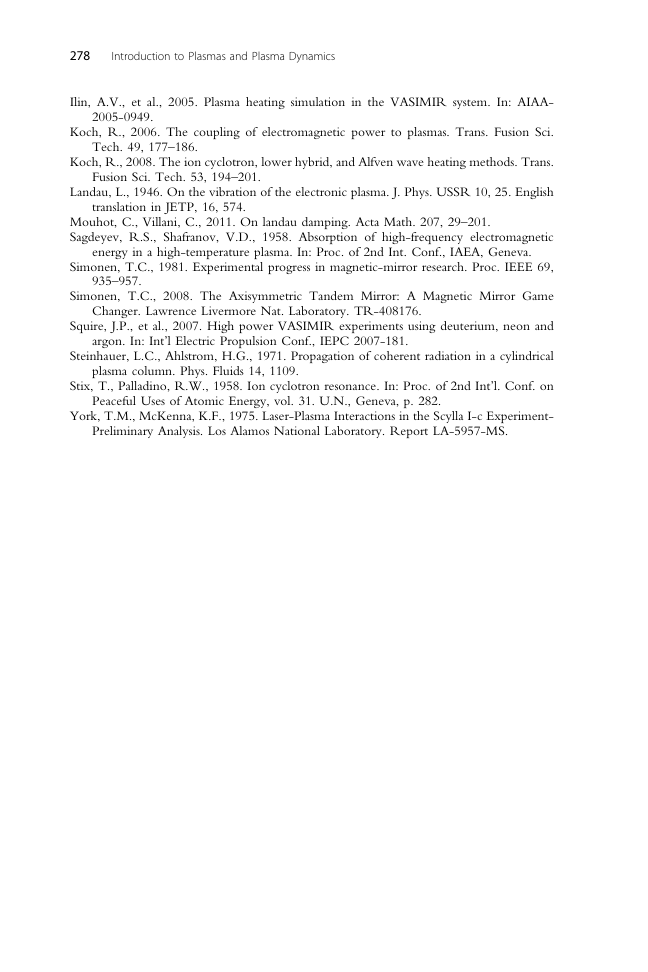

LLM query took 37.93 seconds to process!
(" The image you've provided appears to be a screenshot of a document or "
 'webpage. It includes a title "Nuclear Fusion in confined plasma" and several '
 "bullet points below it. Here's a description of the conditions necessary for "
 'nuclear fusion in a confined plasma as outlined by the text:\n'
 '\n'
 '1. **Energy**: The energy required for nuclear fusion is extremely high, '
 'typically on the order of 10 million degrees Celsius (10^8 K) to overcome '
 'the electrostatic repulsion between atomic nuclei.\n'
 '\n'
 '2. **Density**: For nuclear fusion to occur, the density of the plasma must '
 'be sufficiently high. This is important because at these high densities, the '
 'probability of two nuclei getting close enough together for a fusion '
 'reaction to take place increases significantly.\n'
 '\n'
 '3. **Temperature**: A confined plasma needs to reach temperatures that are '
 'well beyond those found in stars. These conditions are typi

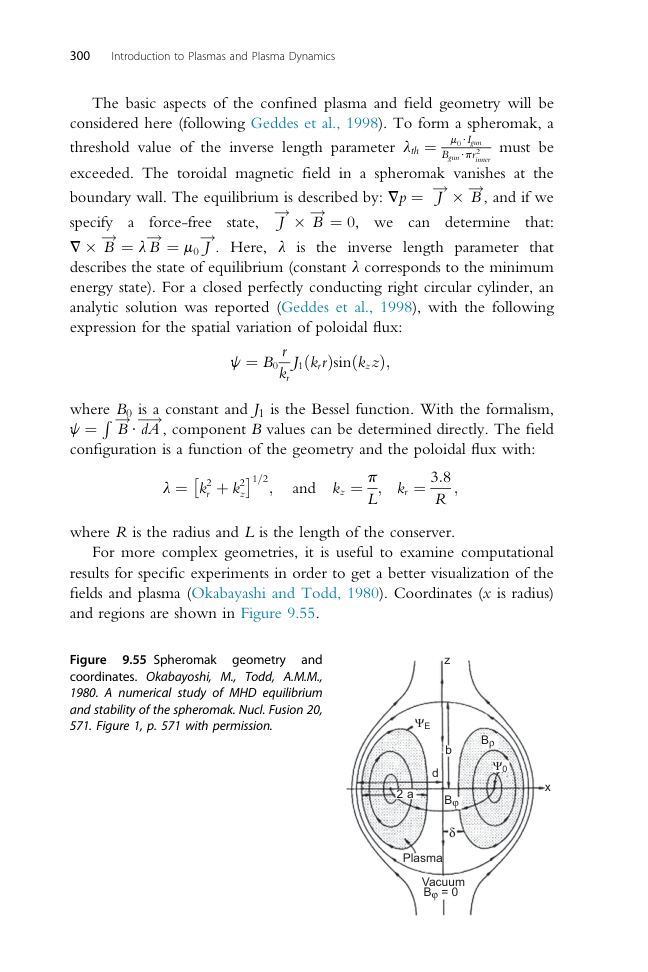

LLM query took 39.52 seconds to process!
(' The image depicts a scientific article page that discusses the conditions '
 'necessary for nuclear fusion in a confined plasma. The text on the page, '
 'while partially obscured, appears to be related to the topic of plasma '
 'physics and specifically, the process of magnetic mirror confinement.\n'
 '\n'
 'The content on the page mentions several key factors:\n'
 '\n'
 '1. **Plasma Temperature**: The article discusses that for nuclear fusion to '
 'occur in a confined plasma, it must reach a high temperature. This is '
 'typically achieved through the use of magnetic fields and other energy input '
 'mechanisms.\n'
 '\n'
 '2. **Density of Charged Particles**: The density of charged particles (such '
 'as ions) in the plasma is critical. At a certain threshold density, nuclear '
 'fusion can occur more efficiently.\n'
 '\n'
 '3. **Magnetic Mirror Confinement**: The article refers to a type of plasma '
 'confinement technique known as magnet

In [18]:
deep_doc_ask( "Describe the conditions necessary for nuclear fusion in a confined plasma." )